In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
#create a transform that is applied to datapoints
transform = transforms.Compose([

    transforms.ToTensor()])

In [7]:
path='~/datasets'
train_dataset=MNIST(path,train=True,transform=transform,download=True)
test_dataset=MNIST(path,train=False,transform=transform,download=True)

In [8]:
batch_size=100
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

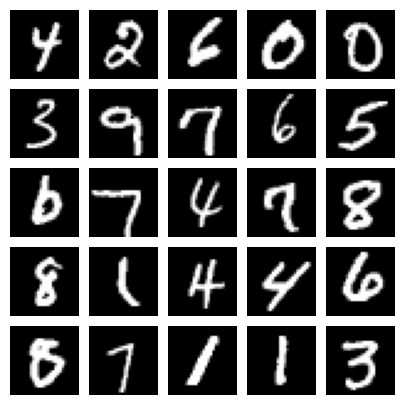

In [16]:
dataiter=iter(train_dataloader)
image=next(dataiter)

num_samples=25
#image[0] extracts the images from the batch, and [i, 0] selects the i-th image from the batch and extracts its first channel (the only channel since mnist images are grayscale)
sample_images=[image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

reparameterization is to enable the training of models with stochastic elements, such as sampling from a probability distribution, while maintaining differentiability. This is crucial for backpropagation-based optimization algorithms.

## Creating the autoencoder

intuition:

In [73]:
class VAE(nn.Module):
  def __init__(self,in_channels=784,hidden_dim=400,latent_dim=200,device=device):
    super(VAE,self).__init__()

    #encoder
    self.encoder=nn.Sequential(nn.Linear(in_channels,hidden_dim),
                               nn.LeakyReLU(0.2),
                               nn.Linear(hidden_dim,latent_dim),
                               nn.LeakyReLU(0.2))

    #latent mean and variance
    self.mean_layer=nn.Linear(latent_dim,2)
    self.logvariance_layer=nn.Linear(latent_dim,2)

    #decoder
    self.decoder=nn.Sequential(nn.Linear(2,latent_dim),
                               nn.LeakyReLU(0.2),
                               nn.Linear(latent_dim,hidden_dim),
                               nn.LeakyReLU(0.2),
                              nn.Linear(hidden_dim,in_channels),
                                nn.Sigmoid())

  def encode(self,x):
    x=self.encoder(x)
    mean, logvar=self.mean_layer(x),self.logvariance_layer(x)
    return mean,logvar
  #mutiplied by epsilon to introduce randomness, else z will be same always
  #epsilon is taken randomly from a guassian distribution to avoid a deterministic transformation and instead get a stochastic network
  def reparameterization(self,mean,var):
    epsilon=torch.randn_like(var).to(device)
    z=mean+ var*epsilon
    return z

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    mean,log_var=self.encode(x)
    z=self.reparameterization(mean,log_var)
    x_hat=self.decode(z)
    return x_hat,mean,log_var


In [74]:
model = VAE().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

## Loss Function

In [75]:
def loss_function(x, x_hat, mean, log_var):
  reproduction_loss=nn.functional.binary_cross_entropy(x_hat,x,reduction='sum')
  KLD=-0.5*torch.sum(1+log_var-mean.pow(2)-log_var.exp())
  return reproduction_loss+KLD

In [76]:
def train(model,optimizer,epochs,device):

  for epoch in range(epochs):
    model.train()
    overall_loss=0
    for i, (x,_) in enumerate(train_dataloader):
      #print(i)
      x=x.view(batch_size,784).to(device)

      optimizer.zero_grad()

      x_hat,mean,log_var=model(x)
      loss = loss_function(x,x_hat,mean,log_var)

      overall_loss+=loss.item()

      loss.backward()
      optimizer.step()

    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/((i+1)*batch_size))
  return overall_loss

In [77]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  175.89504689127605
	Epoch 2 	Average Loss:  157.6060126953125
	Epoch 3 	Average Loss:  152.83947903645833
	Epoch 4 	Average Loss:  149.84413466796875
	Epoch 5 	Average Loss:  147.97209404296876
	Epoch 6 	Average Loss:  146.4844235514323
	Epoch 7 	Average Loss:  145.32180659179687
	Epoch 8 	Average Loss:  144.45865358072916
	Epoch 9 	Average Loss:  143.60039423828124
	Epoch 10 	Average Loss:  142.7966787434896
	Epoch 11 	Average Loss:  142.20359661458335
	Epoch 12 	Average Loss:  141.64454736328125
	Epoch 13 	Average Loss:  140.96792163085937
	Epoch 14 	Average Loss:  140.5730481282552
	Epoch 15 	Average Loss:  140.14894913736978
	Epoch 16 	Average Loss:  139.71618872070312
	Epoch 17 	Average Loss:  139.15716879882814
	Epoch 18 	Average Loss:  138.90145929361978
	Epoch 19 	Average Loss:  138.58202615559895
	Epoch 20 	Average Loss:  138.31326429036457
	Epoch 21 	Average Loss:  137.77349781901043
	Epoch 22 	Average Loss:  137.56721442057292
	Epoch 23 	Average Loss

7988911.7490234375

In [91]:
#generate random digits using random mean and variance
def generate_digit(mean, var):
  z_sample=torch.tensor([[mean,var]],dtype=torch.float).to(device)
  x_decoded=model.decode(z_sample)
  deocded_digit=x_decoded.detach().cpu().reshape(28,28)
  plt.title(f'with the given mean and variance {mean},{var}')
  plt.imshow(deocded_digit,cmap='gray')
  plt.show()


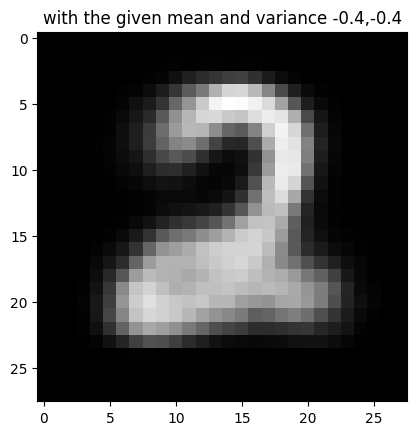

In [101]:
generate_digit(-0.4,-0.4)